In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


## Loading the Environment

In [2]:
import gym
env = gym.make("Taxi-v3").env

### Action Space 

1. Move right
2. Move left
3. Move up
4. Move down
5. Pick up a passenger
6. Drop off a passenger

In [3]:
print("Action Space {}".format(env.action_space))

Action Space Discrete(6)


### State space

1. 5 * 5 possible taxi positions.
2. 5 possible locations of passenger. R, G, B , Y and when he is inside the taxi.
3. 4 destination locations


In [4]:
print("State Space {}".format(env.observation_space))

State Space Discrete(500)


## Rewards

In [5]:
# Need to call reset() at least once before render() will work
# env.P is double dictionary.
# - The 1st key represents the state, from 0 to 499
# - The 2nd key represens the action taken by the agent,
#   from 0 to 5

state = 123
action = 0  # move south
# env.P[state][action][0] is a list with 4 elements
# (probability, next_state, reward, done)
# 
#  - probability
#    It is always 1 in this environment, which means
#    there are no external/random factors that determine the
#    next_state
#    apart from the agent's action a.
#
#  - next_state: 223 in this case
# 
#  - reward: -1 in this case
#
#  - done: boolean (True/False) indicates wheter the
#    episode has ended (i.e. the driver has dropped the
#    passenger at the correct destination)
print('env.P[state][action][0]: ', env.P[state][action][0])

env.P[state][action][0]:  (1.0, 223, -1, False)


In [6]:

env.reset()

env.s = 123
env.render(mode='human')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Q-learning

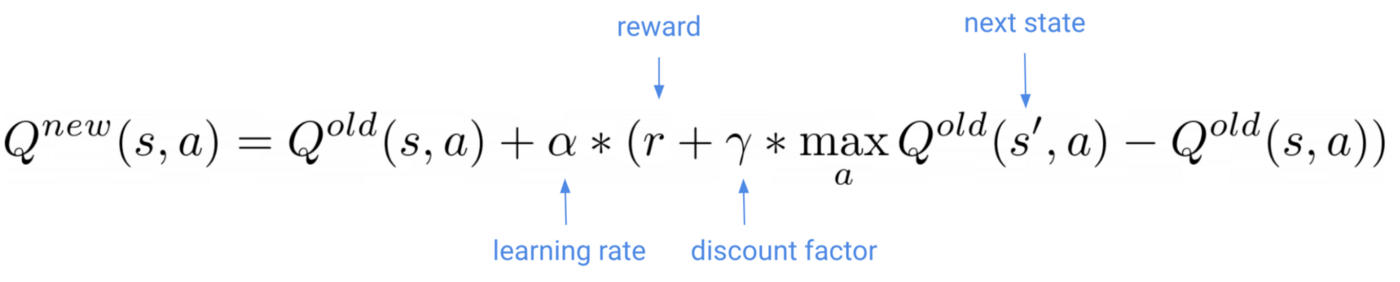

In [7]:
import numpy as np

class QAgent:

    def __init__(self, env, alpha, gamma):
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros([env.observation_space.n,
                                 env.action_space.n])

        # hyper-parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor

    def get_action(self, state):
        """"""
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        """"""
        # Q-learning formula
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        new_value = \
            old_value + \
            self.alpha * (reward + self.gamma * next_max - old_value)

        # update the q_table
        self.q_table[state, action] = new_value

In [9]:
alpha = 0.1
gamma = 0.6

agent = QAgent(env, alpha, gamma)

In [10]:
import random
from tqdm import tqdm

# exploration vs exploitation prob
epsilon = 0.1

n_episodes = 10000

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action) 
        
        agent.update_parameters(state, action, reward, next_state)
        
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 10000/10000 [00:12<00:00, 787.38it/s]


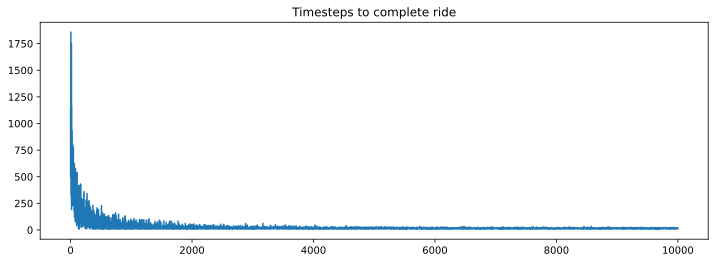

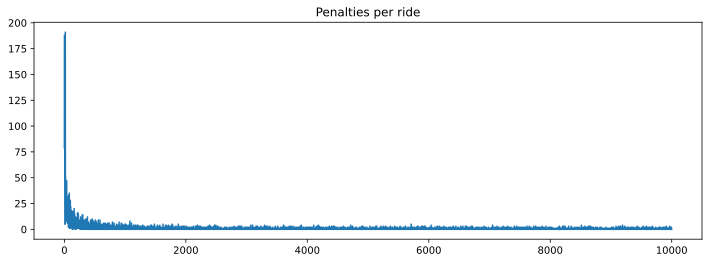

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind='line')
plt.show()

In [12]:
# set initial state of the environment
state = 123
env.s = state

epochs = 0
penalties = 0
reward = 0

# store frames to latter plot them
frames = []

done = False

while not done:
    
    action = agent.get_action(state)
    
    next_state, reward, done, info = env.step(action)
    agent.update_parameters(state, action, reward, next_state)

    if reward == -10:
        penalties += 1
    
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    state = next_state

    epochs += 1
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 11
Penalties incurred: 0


In [16]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1} of {len(frames)}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 11 of 11
State: 479
Action: 5
Reward: 20


In [17]:
import random
from tqdm import tqdm

# exploration vs exploitation prob
epsilon = 0.05

n_episodes = 100

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()      
    
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action)
        
        agent.update_parameters(state, action, reward, next_state)
                      
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
            
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 100/100 [00:00<00:00, 2232.68it/s]


In [18]:
print(f'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}')
print(f'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}')

Avg steps to complete ride: 13.75
Avg penalties to complete ride: 0.2
